# Experiments on Venmo data

In [1]:
from MNLogit_bfgs_torch import MNLogit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os, time

In [2]:
from IPython.display import clear_output
%matplotlib inline

## 1. Load the venmo data
The file name represents the public venmo transaction in October 2017 (Train) and November 2017 (Val), converted into choice data with 63 negative sampling (currently using uniform sampling).

Training data contains 1,060,591 transactions (timestamp `1506816000`-`1509494399`).

Validation data contrains 988,435 transactions (timestamp `1509494400`-`1512086399`).

In [3]:
train_file = "1517443200-1519862400-31536000-0.0100-12-4-4"
val_file   = "1517443200-1519862400-31536000-0.0100-12-4-4"

In [4]:
column_renamer = {0:"pay_id", 1: "timestamp",\
                  2:"payer" , 3:"candidate",4:"y",\
                  5:"Stratified size", 6:"Actual group size",\
                  7:"In TXNs", 8:"Out TXNs",\
                  9:"Unique Friends", 10:"Payer to Candidate",\
                  11:"Candidate to Payer", 12:"#Friends paid Candidate"}

The data is stored in the `.csv` format. One training example has $64$ lines, where the lines $64n$ being the selected candidate of the $n$-th example.

In [5]:
train = pd.read_csv(train_file, header=None, sep=',')\
          .rename(index=int, columns=column_renamer)
train.head()

,pay_id,timestamp,payer,candidate,y,Stratified size,Actual group size,In TXNs,Out TXNs,Unique Friends,Payer to Candidate,Candidate to Payer,#Friends paid Candidate
0,792175010,1517443205,13517628,13782891,1,1,1,52,49,15,8,3,3
1,792175010,1517443205,13517628,10186355,0,4,11,54,80,31,2,0,1
2,792175010,1517443205,13517628,14508947,0,4,11,23,22,23,1,1,4
3,792175010,1517443205,13517628,12665121,0,4,11,57,40,50,0,0,4
4,792175010,1517443205,13517628,13517282,0,4,11,41,21,19,9,1,0


## 2. The original features
The original features are defined by
$$\phi(x_i,x_j) = \begin{bmatrix}
\text{InDeg}(x_j)   \\
\text{OutDeg}(x_j)\\
\text{UniqueDeg}(x_j)\\
\text{Count}(x_i\rightarrow x_j)   \\
\text{Count}(x_j\rightarrow x_i)\\
\text{Count}(x_k: x_i\leftrightarrow x_k \rightarrow x_j)\\
\end{bmatrix}$$

Modified feature are defined to scale down the inputs and address the zeros separately

$$\phi'(x_i,x_j) = \begin{bmatrix}
\text{logz }\phi(x_i,x_j)   \\
\textbf{1}\lbrack\phi(x_i,x_j) > 0\rbrack
\end{bmatrix}$$

$\textbf{1}(\cdot)$ is the indicator function.

$\text{logz }x = \log x \text{ if } x > 0 \text{ else } 0$

This means that the original data is a numpy matrix of shape $(N, 64, 6)$. We then make the 12-feature matrix with $\text{logz}$ and indicators. The resulting matrix has shape $(N, 64, 12)$

In [6]:
train = train.values[:,5:].reshape(-1, 13, 8)
sws = -np.log(train[:,:,0] / train[:,:,1])
Xs = train[:,:,2:]
ys = np.zeros(Xs.shape[0], dtype=int)

Xs = np.concatenate([np.log(Xs + (Xs==0)), 1*(Xs>0)], axis=2)

In [7]:
Xs.shape

(205370, 13, 12)

In [8]:
sws.shape

(205370, 13)

## 3. Fit the parametric model
Import the `MNLogit` and fit the model. The model is fit with __BFGS__ (hessian estimation, not LBFGS) with step-size clipping.

In [9]:
m = MNLogit(num_threads=64)
m.data(Xs, ys, sws=sws)

def show(model, info):
  print("Iter {} - {:.1f}s, ET: {:.1f}s, Avg Loss: {:.6f}, |H\\dw|: {:.6f}, Avg |dw| {:.6f}"\
        .format(info['num_iter'], info['iter_time'], info['total_time'], info['avg_loss'], info['inc_norm'], info['avg_grad_norm']))

m.fit(max_num_iter=300, verbose_function=show)

Iter 1 - 0.4s, ET: 0.4s, Avg Loss: 16.920661, |H\dw|: 688.349097, Avg |dw| 3.351751
Iter 2 - 0.4s, ET: 0.8s, Avg Loss: 14.714689, |H\dw|: 441.756336, Avg |dw| 1.834333
Iter 3 - 0.3s, ET: 1.1s, Avg Loss: 13.062382, |H\dw|: 166.421544, Avg |dw| 1.826171
Iter 4 - 0.4s, ET: 1.5s, Avg Loss: 12.363013, |H\dw|: 293.910080, Avg |dw| 1.829844
Iter 5 - 0.4s, ET: 1.9s, Avg Loss: 11.744420, |H\dw|: 641.502110, Avg |dw| 1.820054
Iter 6 - 0.4s, ET: 2.2s, Avg Loss: 11.170401, |H\dw|: 106.571647, Avg |dw| 1.793693
Iter 7 - 0.4s, ET: 2.6s, Avg Loss: 10.731420, |H\dw|: 77.562769, Avg |dw| 1.771561
Iter 8 - 0.4s, ET: 3.0s, Avg Loss: 10.334108, |H\dw|: 84.439405, Avg |dw| 1.752142
Iter 9 - 0.4s, ET: 3.3s, Avg Loss: 9.930488, |H\dw|: 38.984129, Avg |dw| 1.705954
Iter 10 - 0.3s, ET: 3.7s, Avg Loss: 9.594953, |H\dw|: 38.147833, Avg |dw| 1.649403
Iter 11 - 0.4s, ET: 4.0s, Avg Loss: 9.301812, |H\dw|: 23.541379, Avg |dw| 1.592711
Iter 12 - 0.3s, ET: 4.3s, Avg Loss: 9.023204, |H\dw|: 22.035249, Avg |dw| 1.548556

### 3b. Get the coefficient estimate and the standard error.

In [10]:
info    = m.get_model_info()
weights = info['weights']
se      = info['se']

In [11]:
col_names = ["Log In TXNs","Log Out TXNs","Log Unique Friends","Log Payer to Candidate",
             "Log Candidate to Payer","Log  #Friends paid Candidate"]
pd.DataFrame(np.array([weights[:6], se[:6]]), columns=col_names).rename(index={0:'Estimate',1:'SE'})

,Log In TXNs,Log Out TXNs,Log Unique Friends,Log Payer to Candidate,Log Candidate to Payer,Log #Friends paid Candidate
Estimate,0.108131,-0.187458,0.442656,1.221776,0.192969,-0.329258
SE,0.003352,0.002966,0.005037,0.003950,0.004318,0.005506


In [12]:
col_names = ["In TXNs > 0","Out TXNs > 0","Unique Friends > 0","Payer to Candidate > 0",
             "Candidate to Payer > 0","#Friends paid Candidate > 0"]
pd.DataFrame(np.array([weights[6:], se[6:]]), columns=col_names).rename(index={0:'Estimate',1:'SE'})

,In TXNs > 0,Out TXNs > 0,Unique Friends > 0,Payer to Candidate > 0,Candidate to Payer > 0,#Friends paid Candidate > 0
Estimate,1.043148,0.079479,-0.450711,12.177355,1.565569,1.749936
SE,0.012869,0.009569,0.017431,0.008856,0.007931,0.007959


### 3c. Validation and model evaluation
Import the data in the same way as the training data. Also calculate the same features.

In [13]:
val = pd.read_csv(val_file, header=None, sep=',')\
        .rename(index=int, columns=column_renamer)
val.head()

,pay_id,timestamp,payer,candidate,y,Stratified size,Actual group size,In TXNs,Out TXNs,Unique Friends,Payer to Candidate,Candidate to Payer,#Friends paid Candidate
0,666855866,1509494400,5696532,12122402,1,1,1,60,44,32,0,0,0
1,666855866,1509494400,5696532,2523385,0,5,5,27,44,12,0,0,0
2,666855866,1509494400,5696532,7639272,0,5,5,7,1,2,5,0,1
3,666855866,1509494400,5696532,7648312,0,5,5,10,2,5,1,0,1
4,666855866,1509494400,5696532,10130210,0,5,5,41,30,14,1,0,0


In [14]:
val = val.values[:,5:].reshape(-1, 13, 8)
Xs_val = val[:,:,2:]
ys_val = np.zeros(Xs_val.shape[0], dtype=int)

Xs_val = np.concatenate([np.log(Xs_val + (Xs_val==0)), 1*(Xs_val>0)], axis=2)

In [15]:
Xs_val.shape

(988135, 64, 12)

Evaluate by accuracy. Like in the training set, the labels are all zero. (Probably not a very good practice.)

In [16]:
m.eval(Xs, ys)
m.eval(Xs_val, ys_val)

Accuracy: 260635 / 1060591 (0.2457)
Accuracy: 253681 / 988135 (0.2567)


## 4. Non-parametric models

Previously, we made assumptions on the function form of the scores on the graph features. For __each single feature__, the score takes the expression:
$\text{Score}(x) = \alpha_0\textbf{1}\lbrack x=0 \rbrack + \alpha_1 \text{ logz }x$ 

We want to test whether this assumption is appropriate by fitting non-parametric models $\text{Score}(x) = \beta(i) = \sum_{i=0}^{n_\text{max}} \beta_i \textbf{1}(x=i)$ and see if the parameters for each value of $x$ implies the function $\beta(x)$ of a similar form to $\alpha_0\textbf{1}\lbrack x=0 \rbrack + \alpha_1 \text{ logz }x$.



__Note__

Feature 2 : In-degree (number of transactions in)

Feature 3 : Out-degree (number of transactions out)

Feature 4 : Number of unique friends

Feature 5 : Payer-to-candidates transactions count

Feature 6 : Candidates-to-payer transactions count

Feature 7 : Number of payer's friend that paid each candidate

__Note 2__ Before running the experiments, ensure that there are at least one positive example and one negative example in every bin.

In [17]:
feature = 2
num_bins = 50

Smallest bin size: 6552.0
Data used: 69.12730732204969%


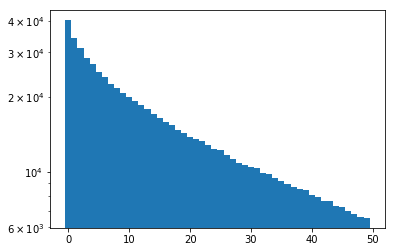

In [18]:
count, _, _ = plt.hist(train[:,0,feature], bins=np.concatenate([np.arange(-0.5,num_bins+.5, 1)]))
plt.yscale('log')
print("Smallest bin size: {}".format(min(count)))
print("Data used: {}%".format(100 * sum(count) / train.shape[0]))

Smallest bin size: 296220.0
Data used: 80.1369341349409%


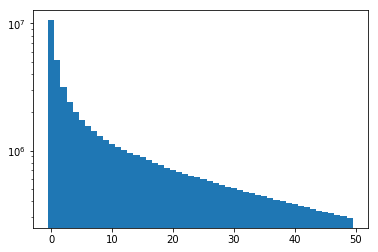

In [19]:
count, _, _ = plt.hist(train[:,1:,feature].reshape(-1), bins=np.arange(-0.5, num_bins+.5, 1))
plt.yscale('log')
print("Smallest bin size: {}".format(min(count)))
print("Data used: {}%".format(100 * sum(count) / train.shape[0] / (train.shape[1] - 1)))

### 4a. Preprocess the data and implement the plot function

In [20]:
def onehot(x, cap=50):
  ncols = min(cap+1, x.max()+1)
  a = np.minimum(x, cap)
  out = np.zeros( (a.size,ncols), dtype=np.float)
  out[np.arange(a.size),a.ravel()] = 1
  out.shape = a.shape + (ncols,)
  return out[...,:-1]

In [21]:
from scipy.stats import linregress

def plot_weight(m, info, feature_name='<feature_name>'):
  clear_output(wait=True)
  plt.figure(figsize=(7,5))
  plot_range = np.arange(0,50).astype(float)
  plot_range[0] = 0.5
  lr = linregress(np.log(np.arange(1,20)), m.w.numpy()[1:20])
  plt.plot(plot_range, lr.slope * np.log(plot_range) + lr.intercept, 'r-', linewidth=0.9, label="slope = {:.4f}".format(lr.slope))
  plt.plot(plot_range, m.w.numpy(), 'kx')
  plt.errorbar(x=plot_range, y=m.w.numpy(), yerr=0 if info['se'] is None else info['se'], color='k', ls='none')
  plt.xscale('log')
  plt.title("Relative coefficients for each bin (by the {})".format(feature_name))
  plt.xlabel(feature_name)
  plt.xlim(0.4,60)
  # plt.ylim(-4.5,0.5)
  ticks = [1,2,3,4,5,6,8,10,15,20,30,40,50]
  plt.xticks([0.5]+ticks, [0]+ticks)
  plt.grid()
  plt.legend()
  print("Iter {} - {:.1f}s, ET: {:.1f}s, Avg Loss: {:.6f}, |H\\dw|: {:.6f}, Avg |dw| {:.6f}"\
        .format(info['num_iter'], info['iter_time'], info['total_time'], info['avg_loss'], info['inc_norm'], info['avg_grad_norm']))

  plt.show();

### 4b. Fit the 6 single-feature models (50 bins)

Iter 94 - 3.5s, ET: 394.9s, Avg Loss: 15.890345, |H\dw|: 0.000000, Avg |dw| 0.000000


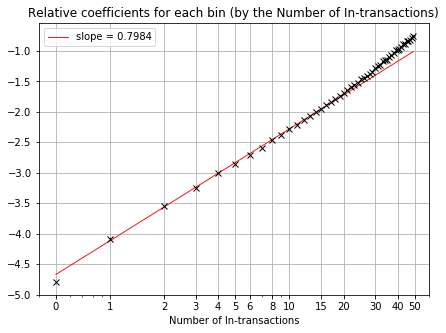

In [22]:
Xs_onehot = onehot(train[:,:,2], cap=50)
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=lambda x,y: plot_weight(x,y,feature_name='Number of In-transactions'))

In [23]:
m.eval(Xs_onehot, ys)

Accuracy: 327665 / 1060591 (0.3089)


Iter 96 - 4.3s, ET: 453.0s, Avg Loss: 16.204315, |H\dw|: 0.000000, Avg |dw| 0.000000


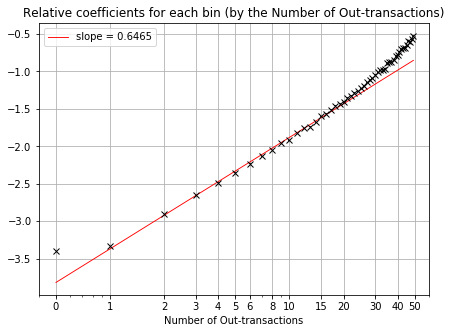

In [24]:
Xs_onehot = onehot(train[:,:,3], cap=50)
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=lambda x,y: plot_weight(x,y,feature_name='Number of Out-transactions'))

In [25]:
m.eval(Xs_onehot, ys)

Accuracy: 265262 / 1060591 (0.2501)


Iter 88 - 4.6s, ET: 426.8s, Avg Loss: 15.981640, |H\dw|: 0.000000, Avg |dw| 0.000000


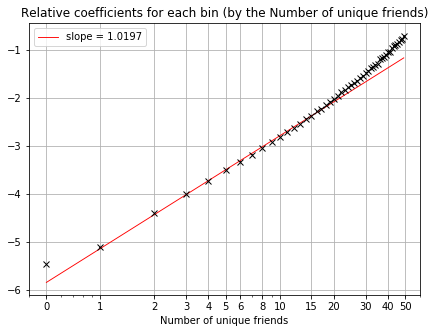

In [26]:
Xs_onehot = onehot(train[:,:,4], cap=50)
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=lambda x,y: plot_weight(x,y,feature_name='Number of unique friends'))

In [27]:
m.eval(Xs_onehot, ys)

Accuracy: 111232 / 1060591 (0.1049)


Iter 73 - 4.4s, ET: 353.1s, Avg Loss: 7.817593, |H\dw|: 0.000000, Avg |dw| 0.000000


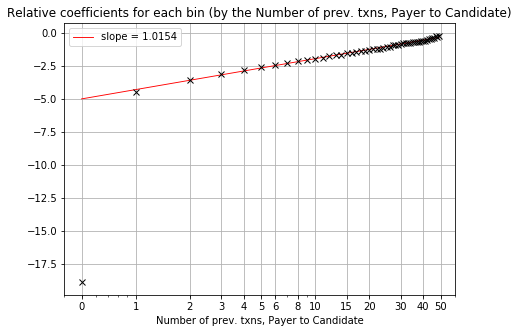

In [28]:
Xs_onehot = onehot(train[:,:,5], cap=50)
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=lambda x,y: plot_weight(x,y,feature_name='Number of prev. txns, Payer to Candidate'))

In [29]:
m.eval(Xs_onehot, ys)

Accuracy: 354912 / 1060591 (0.3346)


Iter 71 - 4.6s, ET: 339.8s, Avg Loss: 10.186106, |H\dw|: 0.000000, Avg |dw| 0.000000


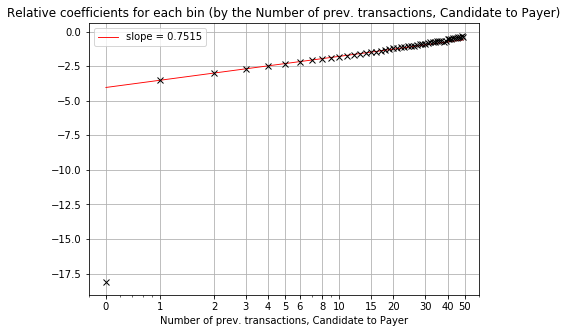

In [30]:
Xs_onehot = onehot(train[:,:,6], cap=50)
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=lambda x,y: plot_weight(x,y,feature_name='Number of prev. transactions, Candidate to Payer'))

In [31]:
m.eval(Xs_onehot, ys)

Accuracy: 386535 / 1060591 (0.3645)


Iter 156 - 4.3s, ET: 759.1s, Avg Loss: 9.457401, |H\dw|: 0.000000, Avg |dw| 0.000000


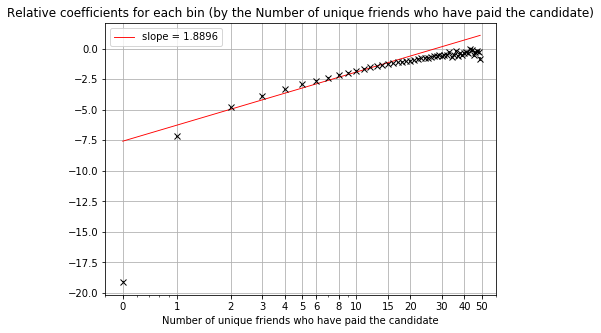

In [32]:
Xs_onehot = onehot(train[:,:,7], cap=50)
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=lambda x,y: plot_weight(x,y,feature_name='Number of unique friends who have paid the candidate'))

In [33]:
m.eval(Xs_onehot, ys)

Accuracy: 230111 / 1060591 (0.2170)


### 4c. Fitting all 6 features simultaneously (= 300 columns)

In [34]:
Xs_onehot = np.concatenate([onehot(train[:,:,2], cap=50), onehot(train[:,:,3], cap=50),
                            onehot(train[:,:,4], cap=50), onehot(train[:,:,5], cap=50),
                            onehot(train[:,:,6], cap=50), onehot(train[:,:,7], cap=50)], axis=2).astype(float)

In [35]:
def plot_weight6(m, info):
  clear_output(wait=True)
  plt.figure(figsize=(7,5))
  labels = ['InDeg', 'OutDeg', 'UniqFriends', 'Payer2Candidate', 'Candidate2Payer','UniqFriendsPaidCandidate']
  plot_range = np.arange(0,50).astype(float)
  plot_range[0] = 0.5
  for i in range(6):
    plt.errorbar(x=plot_range,\
                 y=m.w.numpy()[50*i:50*i+50],\
                 yerr=0 if info['se'] is None else info['se'][50*i:50*i+50],
                 label=labels[i])
  plt.xscale('log')
  plt.title("Relative coefficients for each bin")
  plt.xlabel("Feature value")
  plt.xlim(0.4,60)
  plt.ylim(-4.2,1.2)
  ticks = [1,2,3,4,5,6,8,10,15,20,30,40,50]
  plt.xticks([0.5] + ticks, [0] + ticks)
  plt.grid()
  plt.legend()
  print("Iter {} - {:.1f}s, ET: {:.1f}s, Avg Loss: {:.6f}, |H\\dw|: {:.6f}, Avg |dw| {:.6f}"\
        .format(info['num_iter'], info['iter_time'], info['total_time'], info['avg_loss'], info['inc_norm'], info['avg_grad_norm']))

  plt.show();

Iter 384 - 15.4s, ET: 6823.1s, Avg Loss: 7.555082, |H\dw|: 0.000000, Avg |dw| 0.000000


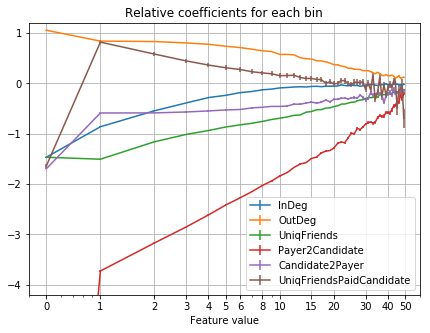

In [36]:
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=plot_weight6)

In [37]:
from scipy.stats import linregress
linregress(np.log(np.arange(1,50)), m.w.numpy()[151:200])

LinregressResult(slope=0.8945181012357872, intercept=-3.871592480860488, rvalue=0.9965178571919976, pvalue=2.2638564216576825e-52, stderr=0.01091729403753097)

In [38]:
m.eval(Xs_onehot, ys)

Accuracy: 261620 / 1060591 (0.2467)


In [39]:
del Xs_onehot
del m

### Note on results
As discussed before, 5 out of 6 single-feature non-parametric model very strongly suggest the given function form (linear on log and zero indicator). However, when we fit the non-parametric models for different feature simultaneously (by concatenating columns), we can see that there are just one feature that actually is linear with $\log (x)$, the `Payer-to-candidate transaction count`.

### 4d. Joint non-parametric model

We want to see if the features have direct interactions with one another. In this experiment, we consider two features (`Payer-to-candidate transaction count` and `Number of unique friends who paid the candidate` (i.e. "mutual friends")). We put the candidates into 20x20 (=400) bins and fit a non-parametric model with 400 parameters to see the joint function form of the parameters.

In [40]:
def flatten_nonparametric(n1, n2, num_bins):
  counted = np.logical_and(n1 < num_bins, n2 < num_bins)
  return n1*counted*num_bins + n2*counted + num_bins*num_bins*(1-counted)

#### Ensure non-zero bin sizes

Smallest bin size: 20.0
Data used: 92.10%


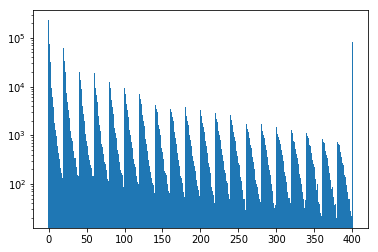

In [41]:
count, _, _ = plt.hist(flatten_nonparametric(train[:,0,5], train[:,0,7], 20), bins=np.concatenate([np.arange(-0.5,401+.5, 1)]))
plt.yscale('log')
print("Smallest bin size: {}".format(min(count)))
print("Data used: {:.2f}%".format(100 * sum(count[:-1]) / train.shape[0]))

Smallest bin size: 89.0
Data used: 99.61%


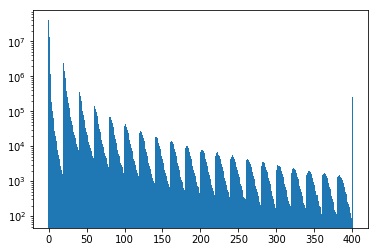

In [42]:
count, _, _ = plt.hist(flatten_nonparametric(train[:,1:,5], train[:,1:,7], 20).reshape(-1), bins=np.concatenate([np.arange(-0.5,401+.5, 1)]))
plt.yscale('log')
print("Smallest bin size: {}".format(min(count)))
print("Data used: {:.2f}%".format(100 * sum(count[:-1]) / train.shape[0] / (train.shape[1] - 1)))

In [43]:
Xs_onehot = onehot(flatten_nonparametric(train[:,:,5], train[:,:,7], 20), cap=400)

In [44]:
m = MNLogit()
m.data(Xs_onehot, ys, sws=sws)
m.fit(max_num_iter=500, verbose_function=show)

Iter 1 - 25.7s, ET: 25.7s, Avg Loss: 16.777224, |H\dw|: 840.307604, Avg |dw| 0.792301
Iter 2 - 35.8s, ET: 61.6s, Avg Loss: 15.984943, |H\dw|: 4747.096741, Avg |dw| 0.792252
Iter 3 - 22.9s, ET: 84.4s, Avg Loss: 15.200326, |H\dw|: 2895.019273, Avg |dw| 0.792137
Iter 4 - 27.2s, ET: 111.7s, Avg Loss: 14.458358, |H\dw|: 2626.994102, Avg |dw| 0.791944
Iter 5 - 20.4s, ET: 132.1s, Avg Loss: 13.786199, |H\dw|: 2390.085491, Avg |dw| 0.791705
Iter 6 - 25.4s, ET: 157.4s, Avg Loss: 13.175329, |H\dw|: 1687.568278, Avg |dw| 0.791429
Iter 7 - 19.5s, ET: 177.0s, Avg Loss: 12.609542, |H\dw|: 1094.682349, Avg |dw| 0.791066
Iter 8 - 21.8s, ET: 198.7s, Avg Loss: 12.085023, |H\dw|: 725.996883, Avg |dw| 0.790543
Iter 9 - 21.2s, ET: 219.9s, Avg Loss: 11.606334, |H\dw|: 505.082560, Avg |dw| 0.789788
Iter 10 - 25.4s, ET: 245.4s, Avg Loss: 11.177026, |H\dw|: 374.337587, Avg |dw| 0.788741
Iter 11 - 22.8s, ET: 268.1s, Avg Loss: 10.798030, |H\dw|: 286.421532, Avg |dw| 0.787368
Iter 12 - 18.7s, ET: 286.9s, Avg Loss:

In [45]:
m.eval(Xs_onehot, ys)

Accuracy: 332655 / 1060591 (0.3137)


In [46]:
m = m.get_model_info()
m['weights'].shape = (20,20)

In [47]:
del Xs_onehot

### 4e. Plot the 400 weights
__I.__ 20 lines plot, each line for different `Numbers of friends who have paid the candidate` 
  * __x-axis__ is `Number of previous transactions (Payer ==> candidates)`

__II.__ ^ x log scale, excludes 0

__III.__ 20 lines plot, each line for different `Number of previous transactions (Payer ==> candidates)`
  * __x-axis__ is `Number of friends who have paid the candidate`

__IV.__ ^ zoomed in for the upper part

__V.__ ^ x log scale, excludes 0

__VI.__ Contour plot where color = coefficient 
  * __x-axis__ is `Number of friends who have paid the candidate`
  * __y-axis__ is `Number of previous transactions (Payer ==> candidates)`, both exclude 0.

__VII.__ y log scale

__VIII.__ ^ log-log

Text(0.5,0,'Number of previous transactions (Payer ==> candidates)')

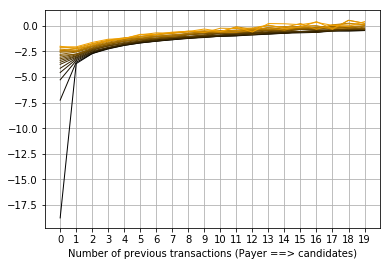

In [67]:
for i in range(20):
  colorcode = hex(256 * (256 * (255 * i // 20) + (170 * i // 20)))[2:]
  colorcode = '0'*(6-len(colorcode)) + colorcode
  plt.plot(m['weights'][:,i],\
           color='#{}'.format(colorcode), linewidth=1)
plt.xticks(range(20),range(20))
plt.grid()
plt.xlabel("Number of previous transactions (Payer ==> candidates)")

Text(0.5,0,'Number of previous transactions (Payer ==> candidates)')

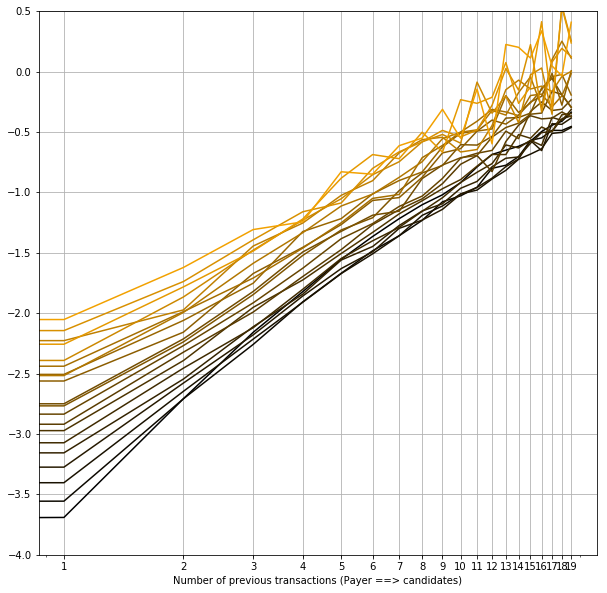

In [64]:
plt.figure(figsize=(10,10))
for i in range(20):
  colorcode = hex(256 * (256 * (255 * i // 20) + (170 * i // 20)))[2:]
  colorcode = '0'*(6-len(colorcode)) + colorcode
  plt.plot(m['weights'][:,i],\
           color='#{}'.format(colorcode))
plt.xscale('log')
plt.ylim(-4,0.5)
plt.xticks(range(1,20),range(1,20))
plt.grid()
plt.xlabel("Number of previous transactions (Payer ==> candidates)")

Text(0.5,0,'Number of friends who have paid the candidate')

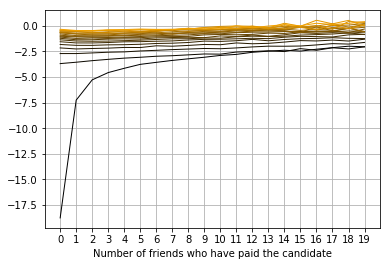

In [66]:
for i in range(20):
  colorcode = hex(256 * (256 * (255 * i // 20) + (170 * i // 20)))[2:]
  colorcode = '0'*(6-len(colorcode)) + colorcode
  plt.plot(m['weights'][i,:],\
           color='#{}'.format(colorcode), linewidth=1)
plt.xticks(range(20),range(20))
plt.grid()
plt.xlabel("Number of friends who have paid the candidate")

Text(0.5,0,'Number of friends who have paid the candidate')

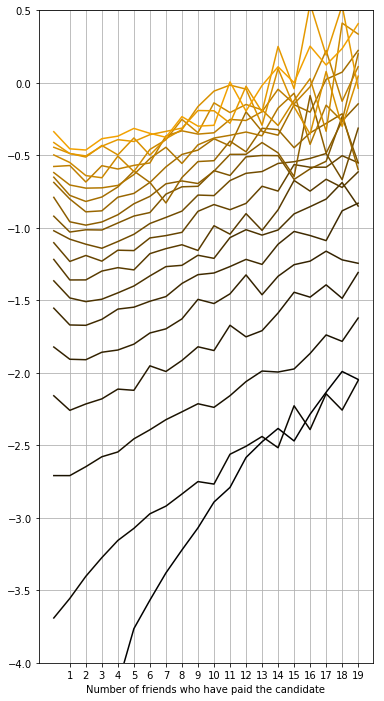

In [72]:
plt.figure(figsize=(6,12))
for i in range(20):
  colorcode = hex(256 * (256 * (255 * i // 20) + (170 * i // 20)))[2:]
  colorcode = '0'*(6-len(colorcode)) + colorcode
  plt.plot(m['weights'][i,:],\
           color='#{}'.format(colorcode))
plt.ylim(-4,0.5)
plt.xticks(range(1,20),range(1,20))
plt.grid()
plt.xlabel("Number of friends who have paid the candidate")

Text(0.5,0,'Number of friends who have paid the candidate')

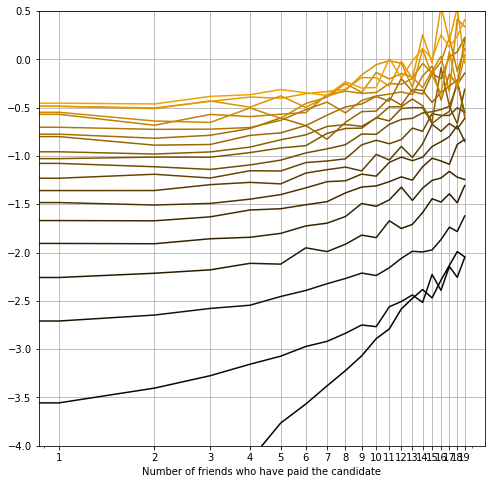

In [71]:
plt.figure(figsize=(8,8))
for i in range(20):
  colorcode = hex(256 * (256 * (255 * i // 20) + (170 * i // 20)))[2:]
  colorcode = '0'*(6-len(colorcode)) + colorcode
  plt.plot(m['weights'][i,:],\
           color='#{}'.format(colorcode))
plt.xscale('log')
plt.ylim(-4,0.5)
plt.xticks(range(1,20),range(1,20))
plt.grid()
plt.xlabel("Number of friends who have paid the candidate")

([<matplotlib.axis.YTick at 0x7f0ad3f66208>,
 <a list of 19 Text yticklabel objects>)

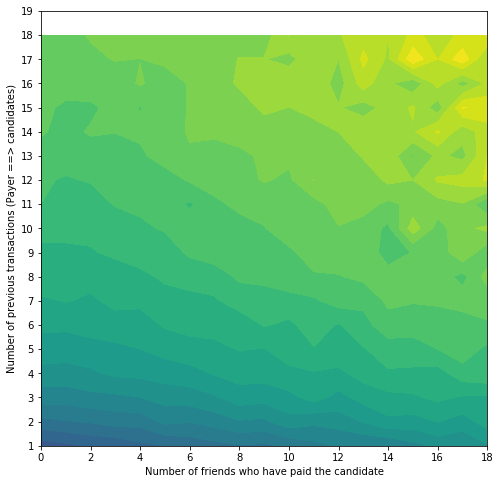

In [77]:
plt.figure(figsize=(8,8))
plt.contourf(m['weights'][1:,1:], levels=np.arange(-4,0.8,0.2))
plt.ylim(1,19)
plt.xlabel("Number of friends who have paid the candidate")
plt.ylabel("Number of previous transactions (Payer ==> candidates)")
plt.yticks(range(1,20), range(1,20))

([<matplotlib.axis.YTick at 0x7f0ad3ed7c50>,
 <a list of 19 Text yticklabel objects>)

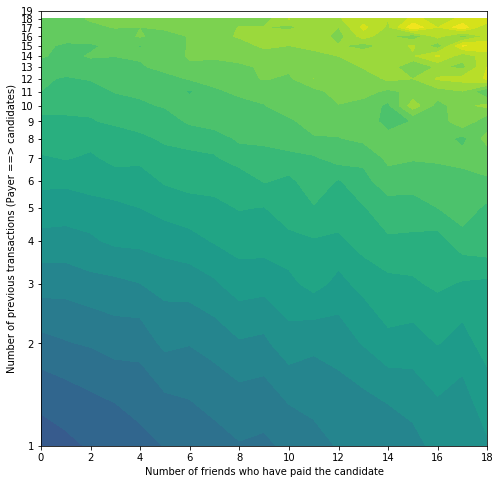

In [78]:
plt.figure(figsize=(8,8))
plt.contourf(m['weights'][1:,1:], levels=np.arange(-4,0.8,0.2))
plt.yscale('log')
plt.ylim(1,19)
plt.xlabel("Number of friends who have paid the candidate")
plt.ylabel("Number of previous transactions (Payer ==> candidates)")
plt.yticks(range(1,20), range(1,20))

([<matplotlib.axis.YTick at 0x7f0ad3c3f780>,
 <a list of 19 Text yticklabel objects>)

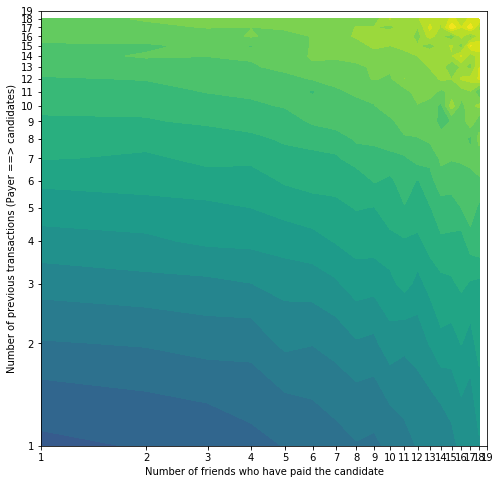

In [81]:
plt.figure(figsize=(8,8))
plt.contourf(m['weights'][1:,1:], levels=np.arange(-4,0.8,0.2))
plt.xlim(1,19)
plt.ylim(1,19)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of friends who have paid the candidate")
plt.ylabel("Number of previous transactions (Payer ==> candidates)")
plt.xticks(range(1,20), range(1,20))
plt.yticks(range(1,20), range(1,20))